# Installs & Imports

In [1]:
!pip install -q xgboost lightgbm dask[dataframe] pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import pmdarima as pm

# Data Loading

In [3]:
# Load the airline passengers dataset
flights = sns.load_dataset('flights')

# Create a datetime column from 'year' and 'month'
flights['date'] = pd.to_datetime(
    flights['year'].astype(str) + '-' +
    flights['month'].astype(str) + '-01'
)
flights = flights.sort_values('date').set_index('date')
flights.rename(columns={'passengers': 'value'}, inplace=True)
print("Data sample:")
display(flights.head())
print(f"\nData shape: {flights.shape}")

Data sample:


,year,month,value
date,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121



Data shape: (144, 3)


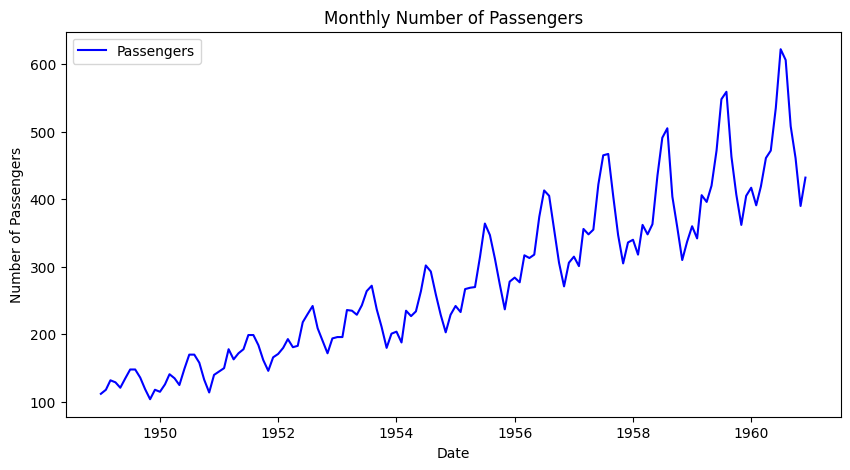

In [4]:
# Plot the data
plt.figure(figsize=(10,5))
plt.plot(flights.index, flights['value'], label='Passengers', color='blue')
plt.title("Monthly Number of Passengers")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

# Data Preparation

## Data Transformation

In [5]:
def guerrero_lambda(series, season_length=12, lower=-2, upper=2, num_candidates=100):
    """Compute the optimal Box–Cox lambda using Guerrero's method."""
    candidate_lambdas = np.linspace(lower, upper, num_candidates)
    best_lambda = None
    best_cv = np.inf

    # Shift the series if there are non-positive values
    shift = 0
    if (series <= 0).any():
        shift = abs(series.min()) + 1
    series_shifted = series + shift

    for lam in candidate_lambdas:
        # Apply the Box–Cox transformation
        if lam == 0:
            transformed = np.log(series_shifted)
        else:
            transformed = (np.power(series_shifted, lam) - 1) / lam

        # Group the transformed values by season (e.g. for monthly data, each month is one group)
        groups = [transformed[i::season_length] for i in range(season_length)]

        # Compute the standard deviation for each season (only if group length > 1)
        sds = np.array([np.std(g, ddof=1) for g in groups if len(g) > 1])
        if np.mean(sds) == 0:
            continue

        # Compute the coefficient of variation (CV) of the seasonal standard deviations
        cv = np.std(sds, ddof=1) / np.mean(sds)

        # Select the lambda that minimizes the CV
        if cv < best_cv:
            best_cv = cv
            best_lambda = lam
    return best_lambda, shift

In [6]:
# Compute optimal lambda using Guerrero's method for our monthly data (season_length=12)
optimal_lambda, shift_val = guerrero_lambda(flights['value'], season_length=12, num_candidates=1000)
print(f"Optimal Guerrero lambda: {optimal_lambda:.4f}, Shift applied: {shift_val}")

Optimal Guerrero lambda: -0.2703, Shift applied: 0


In [7]:
def boxcox_transform(series, lam, shift=0):
    """Apply Box–Cox transformation with given lambda and shift."""
    series_shifted = series + shift
    if lam == 0:
        return np.log(series_shifted)
    else:
        return (np.power(series_shifted, lam) - 1) / lam

In [8]:
def inv_boxcox_transform(transformed, lam, shift=0):
    """Apply the inverse Box–Cox transformation."""
    if lam == 0:
        return np.exp(transformed) - shift
    else:
        return np.power(transformed * lam + 1, 1/lam) - shift

In [9]:
# Apply the Guerrero-based Box–Cox transformation to the target variable
flights['value_transformed'] = boxcox_transform(flights['value'], optimal_lambda, shift_val)

In [10]:
# Check transformed values
transformation_check = flights['value_transformed']
print("Transformation Check:")
display(transformation_check.head())

Transformation Check:


,value_transformed
date,
1949-01-01,2.666384
1949-02-01,2.680861
1949-03-01,2.711279
1949-04-01,2.705117
1949-05-01,2.687752


In [11]:
# Check inverse transformation values
inverse_transformation_check = inv_boxcox_transform(flights['value_transformed'], optimal_lambda, shift_val)
inverse_transformation_check.rename('value_inverse_transformed', inplace=True)
print("Inverse Transformation Check:")
display(inverse_transformation_check.head())

Inverse Transformation Check:


,value_inverse_transformed
date,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [12]:
# Assert inverse_transformation_check == flights['value']
assert np.allclose(inverse_transformation_check, flights['value'], atol=1e-6)
print("Inverse transformation check passed!")

Inverse transformation check passed!


## Feature Engineering

In [13]:
def add_fourier_features(df, period=12, order=3):
    """
    Adds Fourier features (sine and cosine terms) to capture seasonality.
    For monthly data, period=12 is appropriate.
    """
    df = df.copy()
    t = np.arange(len(df))
    for k in range(1, order + 1):
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return df

In [14]:
def create_lagged_features(df, target_column, lags):
    """
    Creates lagged features for the target column.
    For instance, lag_1 is the value from one time-step before.
    """
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df.dropna(inplace=True)  # Remove rows with missing values caused by shifting
    return df

In [15]:
# Create Fourier features
flights = add_fourier_features(flights, period=12, order=4)

# Create lagged features
flights = create_lagged_features(flights, 'value_transformed', lags=12)

# Create exponential moving average (EWM) features
flights['ema_3'] = flights['value_transformed'].ewm(span=3, adjust=False).mean()
flights['ema_6'] = flights['value_transformed'].ewm(span=6, adjust=False).mean()
flights['ema_12'] = flights['value_transformed'].ewm(span=12, adjust=False).mean()

# Create datetime features
flights['year'] = flights.index.year
flights['month'] = flights.index.month

# Create time index feature (linear trend)
flights['trend'] = np.arange(len(flights))

# Print shape
print(f"Data shape after feature engineering: {flights.shape}")

Data shape after feature engineering: (132, 28)


In [16]:
# Display the data
display(flights.head())

,year,month,value,value_transformed,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,...,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ema_3,ema_6,ema_12,trend
date,,,,,,,,,,,,,,,,,,,,,
1950-01-01,1950,1,115,2.673742,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0,-7.347881e-16,1.000000e+00,...,2.717266,2.687752,2.705117,2.711279,2.680861,2.666384,2.673742,2.673742,2.673742,0
1950-02-01,1950,2,126,2.698770,5.000000e-01,8.660254e-01,8.660254e-01,0.5,1.000000e+00,2.572377e-15,...,2.741384,2.717266,2.687752,2.705117,2.711279,2.680861,2.686256,2.680893,2.677593,1
1950-03-01,1950,3,141,2.728749,8.660254e-01,5.000000e-01,8.660254e-01,-0.5,8.572528e-16,-1.000000e+00,...,2.741384,2.741384,2.717266,2.687752,2.705117,2.711279,2.707502,2.694566,2.685463,2
1950-04-01,1950,4,135,2.717266,1.000000e+00,1.194340e-15,2.388680e-15,-1.0,-1.000000e+00,8.578717e-16,...,2.719225,2.741384,2.741384,2.717266,2.687752,2.705117,2.712384,2.701052,2.690356,3
1950-05-01,1950,5,125,2.696611,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,-9.797174e-16,1.000000e+00,...,2.683182,2.719225,2.741384,2.741384,2.717266,2.687752,2.704498,2.699783,2.691318,4


## Data Splitting

In [17]:
def split_time_series(data, test_size=24, by_percentage=False):
    """
    Splits time series data into training and test sets.

    Parameters:
        data (pd.DataFrame): The full dataset.
        test_size (int or float):
            - If by_percentage is False (default), test_size is the number of observations for testing.
            - If by_percentage is True, test_size is a fraction (e.g., 0.2 for 20%).
        by_percentage (bool): Flag to determine if test_size is a percentage.

    Returns:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.
    """
    if by_percentage:
        # When test_size is a fraction, compute the train size accordingly
        train_size = int(len(data) * (1 - test_size))
    else:
        # When test_size is an integer, the train set consists of all but the last test_size observations
        train_size = len(data) - test_size

    train = data.iloc[:train_size]
    test = data.iloc[train_size:]
    return train, test

In [18]:
# # Split by percentage
# train, test = split_time_series(flights, test_size=0.2, by_percentage=True)
# print(f"Training samples: {len(train)}, Test samples: {len(test)}")

In [19]:
# Split by fixed number
train, test = split_time_series(flights, test_size=24)
print(f"Training samples: {len(train)}, Test samples: {len(test)}")

Training samples: 108, Test samples: 24


In [20]:
# Prepare feature matrices and target vectors
# Exclude the original and transformed target values from features
X_train = train.drop(['value', 'value_transformed'], axis=1)
y_train = train['value_transformed']
X_test = test.drop(['value', 'value_transformed'], axis=1)
y_test = test['value_transformed']

# Print shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (108, 26), y_train shape: (108,)
X_test shape: (24, 26), y_test shape: (24,)


# Model Initialization

In [21]:
from sklearn.utils import validation

# Monkey-patching deprecated 'force_all_finite' to new 'ensure_all_finite'
# Only patch if not already patched
if not hasattr(validation.check_array, '_original'):
    # Save a reference to the original function
    original_check_array = validation.check_array

    def patched_check_array(*args, **kwargs):
        # Remap the old parameter name to the new one if provided
        if 'force_all_finite' in kwargs:
            kwargs['ensure_all_finite'] = kwargs.pop('force_all_finite')
        return patched_check_array._original(*args, **kwargs)

    # Store the original function in an attribute
    patched_check_array._original = original_check_array

    # Mark the function as patched
    patched_check_array._monkey_patched = True

    # Replace the original function with the patched version
    validation.check_array = patched_check_array

In [22]:
# 1. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)

# 2. XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=300, random_state=42)

# 3. LightGBM Regressor
lgb_model = lgb.LGBMRegressor(n_estimators=300, random_state=42, verbose=-1)

# 4. AutoARIMA Model
arima_model = pm.auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=12,  # For monthly data, seasonal period m=12
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-622.796, Time=9.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-487.143, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=3.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-549.715, Time=2.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-488.095, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-555.264, Time=7.91 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-635.144, Time=3.63 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-507.326, Time=1.99 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-650.746, Time=2.82 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-620.379, Time=4.76 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=-650.637, Time=1.77 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=-651.137, Time=4.49 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-639.736, Time=0.93 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=-624.643, Time=1.09 sec
 ARIMA(2,1,1)(1,0,1)[12]

# Model Fitting

In [23]:
# Fit the tree-based models on the training data
# AutoARIMA model is automatically fitted during the auto_arima call
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
print("Models fitted!")

Models fitted!


# Model Forecasts

In [24]:
# Obtain predictions on the test set
# Predictions are on the transformed scale
rf_pred_transformed = rf_model.predict(X_test)
xgb_pred_transformed = xgb_model.predict(X_test)
lgb_pred_transformed = lgb_model.predict(X_test)
arima_pred_transformed = arima_model.predict(n_periods=len(X_test), exogenous=X_test)

In [25]:
# Convert predictions back to the original scale using the inverse Box–Cox transformation
rf_pred = inv_boxcox_transform(rf_pred_transformed, optimal_lambda, shift_val)
xgb_pred = inv_boxcox_transform(xgb_pred_transformed, optimal_lambda, shift_val)
lgb_pred = inv_boxcox_transform(lgb_pred_transformed, optimal_lambda, shift_val)
arima_pred = inv_boxcox_transform(arima_pred_transformed, optimal_lambda, shift_val)

In [26]:
# Convert the actual test target back to the original scale for evaluation
y_test_original = inv_boxcox_transform(y_test, optimal_lambda, shift_val)

# Metrics Evaluation

In [27]:
def rmse_fn(y_true, y_pred):
    """Root Mean Squared Error"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae_fn(y_true, y_pred):
    """Mean Absolute Error"""
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [28]:
# Calculate metrics for each model
models_metrics = {
    'Model': ['RandomForest', 'XGBoost', 'LightGBM', 'AutoARIMA'],
    'RMSE': [
        rmse_fn(y_test_original, rf_pred),
        rmse_fn(y_test_original, xgb_pred),
        rmse_fn(y_test_original, lgb_pred),
        rmse_fn(y_test_original, arima_pred)
    ],
    'MAE': [
        mae_fn(y_test_original, rf_pred),
        mae_fn(y_test_original, xgb_pred),
        mae_fn(y_test_original, lgb_pred),
        mae_fn(y_test_original, arima_pred)
    ],
    'MAPE': [
        mape(y_test_original, rf_pred),
        mape(y_test_original, xgb_pred),
        mape(y_test_original, lgb_pred),
        mape(y_test_original, arima_pred)
    ],
    'sMAPE': [
        smape(y_test_original, rf_pred),
        smape(y_test_original, xgb_pred),
        smape(y_test_original, lgb_pred),
        smape(y_test_original, arima_pred)
    ]
}

In [29]:
# Display metrics DataFrame
metrics_df = pd.DataFrame(models_metrics)
print("Forecasting Metrics:")
display(metrics_df)

Forecasting Metrics:


,Model,RMSE,MAE,MAPE,sMAPE
0,RandomForest,50.988011,35.170005,6.991091,7.411255
1,XGBoost,55.076870,46.429747,9.758026,10.395289
2,LightGBM,73.304255,62.528928,13.043097,14.173200
3,AutoARIMA,35.359061,32.176496,6.980689,7.276566


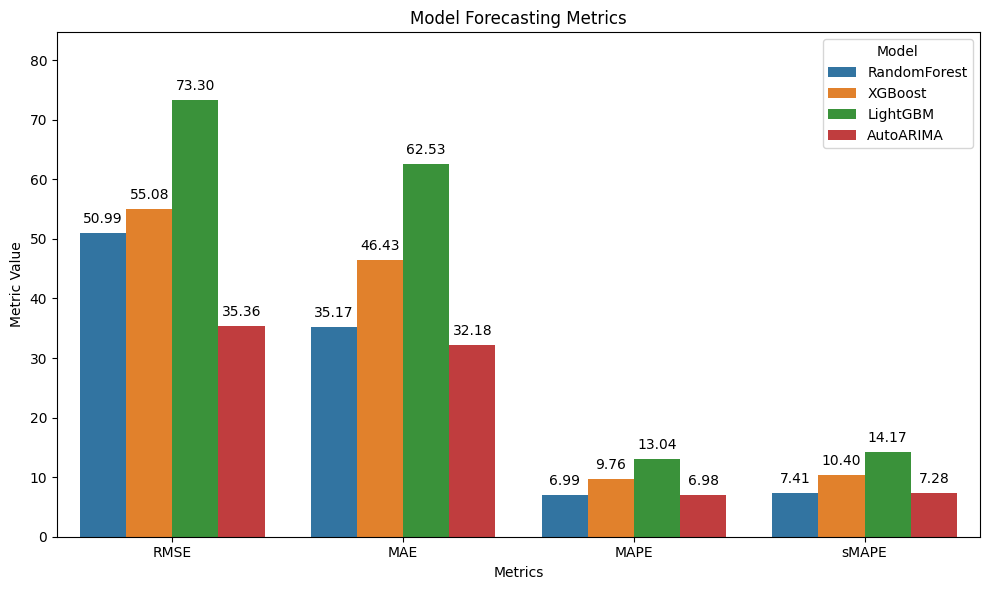

In [30]:
# Reshape the DataFrame for plotting
df_melted = pd.melt(metrics_df, id_vars='Model', var_name='Metric', value_name='Value')

# Create the grouped bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Value', hue='Model', data=df_melted)

# Annotate each bar with its corresponding value
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{height:.2f}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points'
        )

# Extend the y-axis limit slightly above the highest bar
current_ylim = ax.get_ylim()
ax.set_ylim(current_ylim[0], current_ylim[1] * 1.1)

plt.title('Model Forecasting Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Metrics')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Forecast Plotting

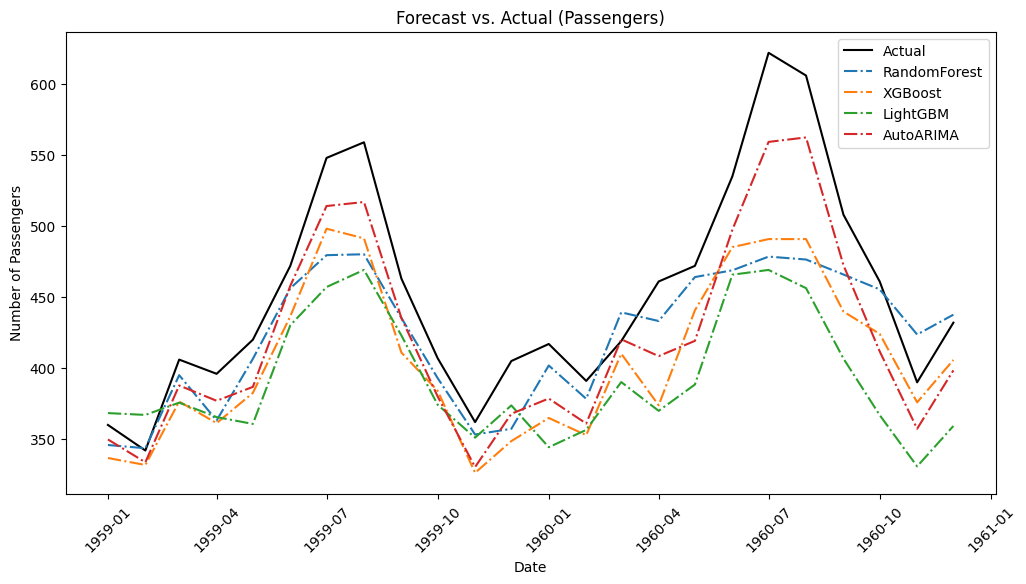

In [31]:
# Plot the forecasts versus the actual test set values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test_original, label='Actual', color='black')
plt.plot(test.index, rf_pred, label='RandomForest', linestyle='-.')
plt.plot(test.index, xgb_pred, label='XGBoost', linestyle='-.')
plt.plot(test.index, lgb_pred, label='LightGBM', linestyle='-.')
plt.plot(test.index, arima_pred, label='AutoARIMA', linestyle='-.')
plt.title("Forecast vs. Actual (Passengers)")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.xticks(rotation=45)
plt.legend()
plt.show()